In [61]:
import math

In [100]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.8f | grad %.10f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [110]:
class Value:
    def __init__(self, data, children = (), label = "", op = ""):
        self.data = data
        self.grad = 0.0
        self._prev = children
        self.backward = lambda: None
        self.label = label
        self._op = op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label="cnst")
        dat = self.data + other.data
        val = Value(dat, (self, other), op = "+")
        def backward():
            self.grad += 1.0 * val.grad
            other.grad += 1.0 * val.grad

        val.backward = backward
        return val

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label="cnst")
        dat = self.data * other.data
        val = Value(dat, (self, other), op = "*")
        def backward():
            self.grad += other.data * val.grad
            other.grad += self.data * val.grad

        val.backward = backward
        return val
    
    def __pow__(self, poww):
        dat  = self.data ** poww
        val = Value(dat, (self,), op="**")
        def backward():
            self.grad += poww * (self.data ** (poww-1)) * val.grad
        
        val.backward = backward
        return val
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        return self + (-1 * other)
    
    def exp(self):
        dat = math.exp(self.data)
        val = Value(dat, (self,), op="ex")
        def backward():
            self.grad += dat * val.grad
        
        val.backward = backward
        return val
    
    def tanh_explode(self):
        expp = (2*self).exp()
        return (expp - 1) * ((expp + 1) ** -1)
    
    def tanh(self):
        dat = self.data
        compu = (math.exp(2*dat) - 1) / (math.exp(2*dat) + 1)
        val = Value(compu, (self,), op = "tanh")
        def backward():
            self.grad += (1 - (compu ** 2)) * val.grad

        val.backward = backward
        return val
    
    def __repr__(self):
        return f" Data: {self.data} Grad: {self.grad} Label: {self.label} OP: {self._op} "
    

    def backward_run(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node.backward()
        

In [111]:
j = Value(8, label = "j")
k = j.tanh_explode()
l = k + 1

l.backward_run()

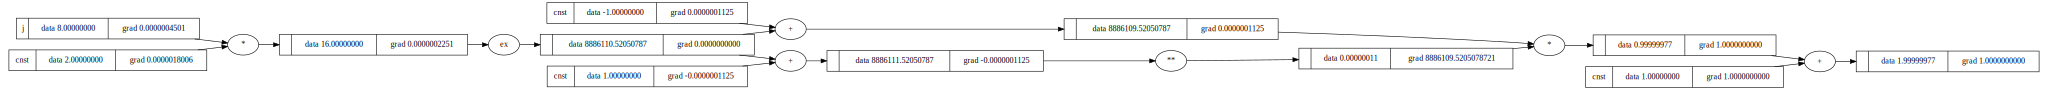

In [112]:
draw_dot(l)

In [117]:
a = Value(8, label = "a")
b = Value(4, label = "b")

c = a * b
d = a + b

e = c + d

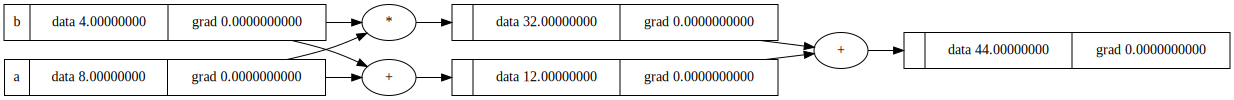

In [115]:
draw_dot(e)

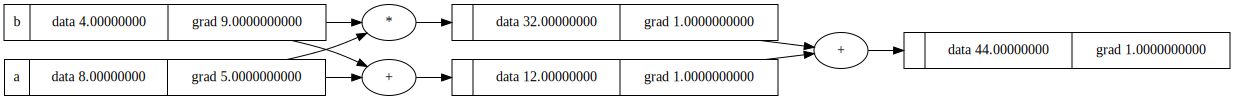

In [116]:
e.grad = 1.0
e.backward()
c.backward()
d.backward()
draw_dot(e)

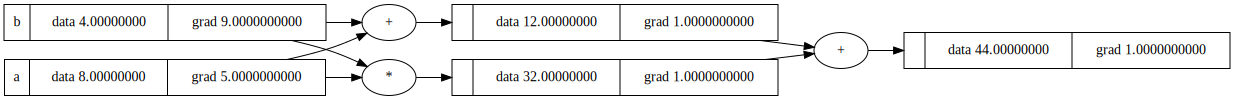

In [118]:
e.backward_run()
draw_dot(e)